# Assignment Natural Disaster

###### Loading preparation of the data

Before training any model for any one the tasks, we need to load, explore and prepare the data. The data is locally saved. 

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt 
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.model_selection import train_test_split
import nltk
from nltk.stem import WordNetLemmatizer

The info on the data will provide some intuition about the amount of the data we have, type of each of the input columns and the amount data missing.

In [3]:
my_train = pd.read_csv('train.csv')
my_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [4]:
my_train.nunique()

id          7613
keyword      221
location    3341
text        7503
target         2
dtype: int64

We check the percentage of the missing values in data, and decide to which columns to keep and which not to. Based on the analysis, the <span style="color:red">location</span> has 33% missing values. We decide to remove the column and not to use it in the classifciation. Another column which has missing values is <span style="color:green">keyword</span> which had 0.8% missing data. Since this is a small portion, I will keep this column and using empty string for filling the missing values in this column. <span style="color:red"> id</span> is another column that we drop since it has the unique identification of each of the tweets. 
I also remove the duplicate rows that have the *same Keyword and text*.
Another decision I made here in preparation of the data is to combine **keyword** and **text** as a new column to work with at the same time. 
> **Note**: The combination I made is a simle addding of keyword to the text but another way to do is to have a weight on the keywords to make them more powerful in the prediction process. 


In [5]:
#chack for the missing values 
my_train.isnull().sum()/len(my_train)

id          0.000000
keyword     0.008013
location    0.332720
text        0.000000
target      0.000000
dtype: float64

In [6]:
#assumption is that the classification would be based on the text 
#so I drop the id and the location (since location has 33 percent nul values)
my_train = my_train.drop(columns=['id','location'])

# I can also drop the rows without keyword ( at this posint I decisde to keep them and fill them with empty string)
my_train['keyword'] = my_train['keyword'].fillna('')

In [7]:
my_train.isnull().sum()/len(my_train)

keyword    0.0
text       0.0
target     0.0
dtype: float64

In [8]:
# remove duplicates
my_train.drop_duplicates(keep = 'first', inplace = True)

# make of combination of the keyword and text
my_train['message'] = my_train['keyword']+' '+my_train['text']


In [9]:
my_train.shape

(7541, 4)

In [10]:
#check if there is any misslabel in the dataset
my_train.target.unique()

array([1, 0], dtype=int64)

I check the number of observations in each of the classes and if the classes are in balanced. While the number of fake tweets are more, the ratio is not as high to consider it as imbalance

In [11]:
real = my_train[my_train.target ==1].shape[0]
fake = my_train[my_train.target ==0].shape[0]

print(f'real:fake ratio is 1:{fake/real}')

real:fake ratio is 1:1.3390198511166254


[Text(0.5, 1.0, 'Number of Fake vs Real tweets')]

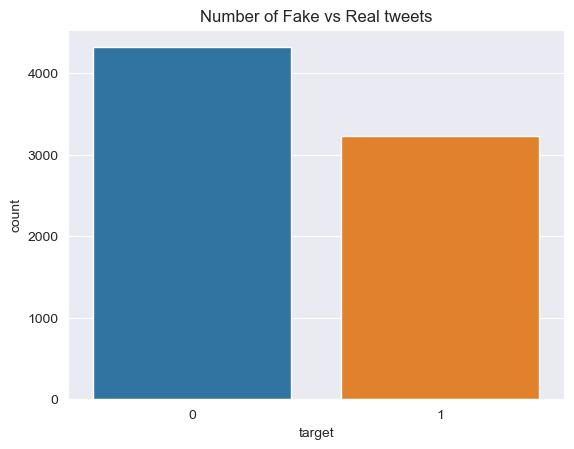

In [12]:
# plot the classes
target = my_train['target']
sns.set_style('darkgrid')
sns.countplot(target).set(title = 'Number of Fake vs Real tweets')

###### Preprocess the tweets
For the preprocessing of the data, the data need to be tokenized and clean. 
since these are the tweets, before general preprocessing that we do for normal text, we do some tweet preprocessing which includes removing URL's , Mentions, hashtags, Emojis, Smileys and some specific words To do so we use a the python tweet-preprocessor library. After tweet preprocessing, we apply other preprocessings as follow:

1. lower the tweet
2. remove any punctuation
3. remove extra spaces
4. remove the stopword
5. stemming or lemmatizing the tokens(words). I use the lemmatization since it keeps the word in correct format regarding their meanings.



In [13]:
#tweet preprocessing
import preprocessor as tweet_preproc
def preproc_tweet(doc):
    processed = tweet_preproc.clean(doc)
    return processed

In [14]:
# the preprocessing
import re
def preprocessing(message):
    
    
    #chaneg sentence to lowercase
    message = message.lower()
   #remove punctuations
    message = re.sub(r'[^\w\s]',' ',message)
    #remove extra scpace
    message = re.sub(r'\s\s+',' ',message)
    #tokenize into words
    words = word_tokenize(message)
    
    #remove stopwords
    words = [word for word in words if word not in stopwords.words("english")]
    
    #lematization
    wordnet_lemmatizer = WordNetLemmatizer()
    words = [wordnet_lemmatizer.lemmatize(w)  for w in words]
    
    return ' '.join(words)

In [15]:
# select the columns we need
data = my_train.loc[:,['message','target']]

#preprocess the messages 
data['message'] = data['message'].apply(preproc_tweet)
data['processed_messages'] = data['message'].apply(preprocessing)



In [16]:
data['processed_messages'].head(10)

0                      deed reason may allah forgive u
1                forest fire near la ronge sask canada
2    resident asked shelter place notified officer ...
3           people receive evacuation order california
4               got sent photo ruby smoke pours school
5    update california hwy closed direction due lak...
6    heavy rain cause flash flooding street manitou...
7                               top hill see fire wood
8    emergency evacuation happening building across...
9                           afraid tornado coming area
Name: processed_messages, dtype: object

###### splitting data for training and test
To do so I select the columns for corpus *processed_messages* and the labels *target*. 
Stratify is used in the process of the splitting to make sure that the test set also have the same distribution of the "real" and "fake" tweets as training set.


In [17]:
# make the corpus and labels
corpus = data['processed_messages'].tolist()
labels = data['target'].tolist()

In [18]:
#seperate train-test set

x_train,x_test,y_train,y_test = train_test_split(corpus,labels,test_size=0.2, random_state = 123,stratify=labels, shuffle=True)

##### Bag of Words model
In this step the tweets are modeled using BoW method and then a linear classification model is used to classify the tweets.

In [19]:
def countvectorizer(data):
    
    count_vectorizer = CountVectorizer()
    
    emb = count_vectorizer.fit_transform(data)
    
    return emb , count_vectorizer

In [20]:
# Make bag of words for the dataset based on the  x_train 
x_train_counts, count_vectorization = countvectorizer(x_train)

# make the vector for the test set(x_test)
x_test_counts = count_vectorization.transform(x_test)

In [21]:
x_train_counts.shape

(6032, 10744)

In [22]:
#prepare the train and test data to use for the classification model
x_train_bow = x_train_counts.toarray()
x_test_bow = x_test_counts.toarray()

Since the number of feature (10744) is huge compare to the number of observations in the training data set (6032) we choose the algorithms with high bias/ low varience like logistic regression, Naive Bays and linear SVM. Also I checked bagging algorithm (Random forest) to see its performance on this data.   

In [23]:
#simplest model Naive bayes
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,precision_score, recall_score, f1_score, plot_confusion_matrix
import scikitplot as skplt


In [24]:
def plot_roc(model,x_test,y_test,model_name):
    from sklearn.metrics import roc_auc_score
    from sklearn.metrics import roc_curve
    logit_roc_auc = roc_auc_score(y_test, model.predict(x_test))
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(x_test)[:,1])
    plt.figure()
    plt.plot(fpr, tpr, label=f'{model_name} (area = %0.2f)' % logit_roc_auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.savefig('Log_ROC')
    plt.show()

In [25]:
def evaluate(model,X_train,y_train, X_test,y_test, model_name): 
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    print(f'Evaluation of the {model_name} model on test set')
    plot_confusion_matrix(model, X_test, y_test, display_labels = ['Fake','Real'],cmap='PuBu')
    plt.show()
    print('Precision: %.3f' % precision_score(y_test, y_pred))
    print('Recall: %.3f' % recall_score(y_test, y_pred))
    print('F1: %.3f' % f1_score(y_test, y_pred))
    print('Accuracy: %.3f' % accuracy_score(y_test, y_pred))
    if model_name !='svm':
        plot_roc(model,X_test,y_test,model_name)

In [26]:
mnb_model = MultinomialNB()
lr_model = LogisticRegression()
svm_model = LinearSVC()
rf_model = RandomForestClassifier()


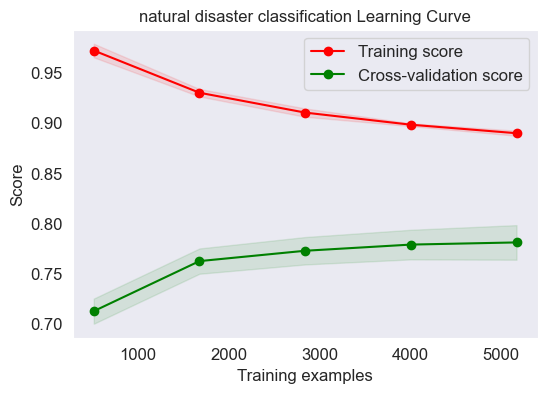

In [27]:
skplt.estimators.plot_learning_curve(mnb_model, x_train_bow,y_train,
                                     cv=7, shuffle=True, scoring="accuracy",
                                     n_jobs=-1, figsize=(6,4), title_fontsize="large", text_fontsize="large",
                                     title="natural disaster classification Learning Curve");

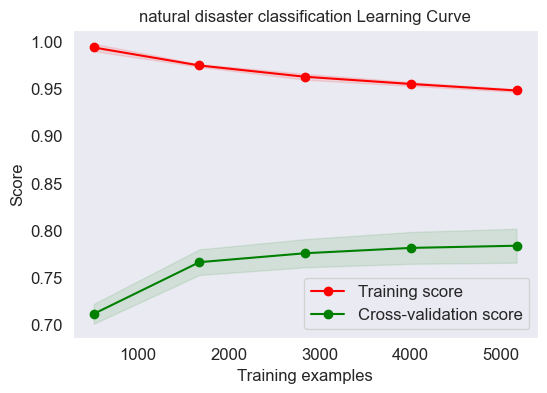

In [28]:
skplt.estimators.plot_learning_curve(lr_model, x_train_bow,y_train,
                                     cv=7, shuffle=True, scoring="accuracy",
                                     n_jobs=-1, figsize=(6,4), title_fontsize="large", text_fontsize="large",
                                     title="natural disaster classification Learning Curve");

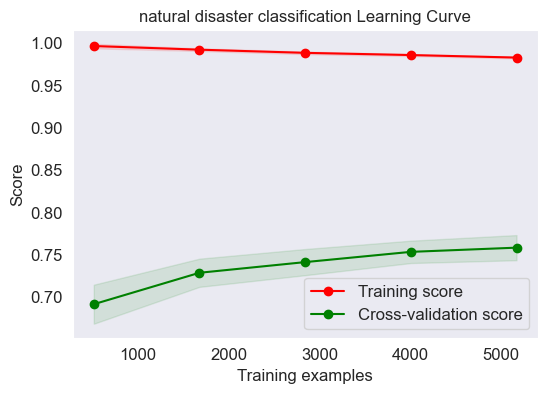

In [29]:
skplt.estimators.plot_learning_curve(svm_model, x_train_bow,y_train,
                                     cv=7, shuffle=True, scoring="accuracy",
                                     n_jobs=-1, figsize=(6,4), title_fontsize="large", text_fontsize="large",
                                     title="natural disaster classification Learning Curve");

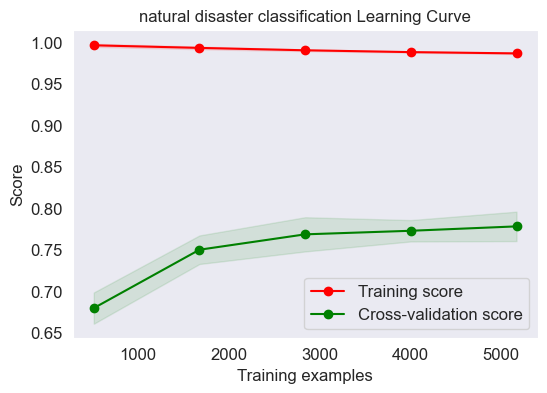

In [30]:
skplt.estimators.plot_learning_curve(rf_model, x_train_bow,y_train,
                                     cv=7, shuffle=True, scoring="accuracy",
                                     n_jobs=-1, figsize=(6,4), title_fontsize="large", text_fontsize="large",
                                     title="natural disaster classification Learning Curve");

Evaluation of the Naive Bayes model on test set


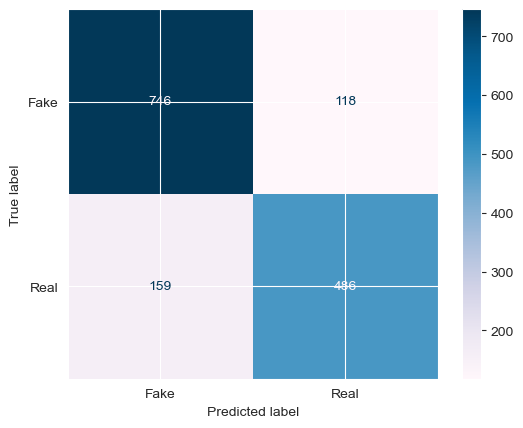

Precision: 0.805
Recall: 0.753
F1: 0.778
Accuracy: 0.816


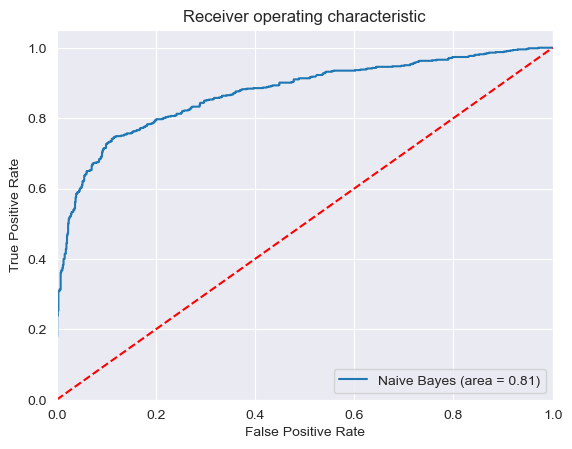

In [31]:
evaluate(mnb_model,x_train_bow,y_train, x_test_bow,y_test,'Naive Bayes')

Evaluation of the Linear regression model on test set


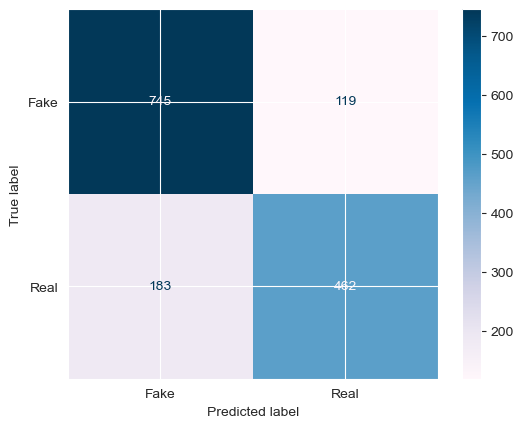

Precision: 0.795
Recall: 0.716
F1: 0.754
Accuracy: 0.800


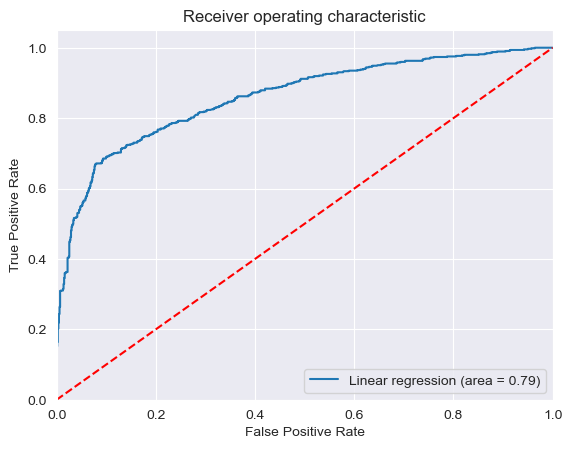

In [32]:
evaluate(lr_model,x_train_bow,y_train, x_test_bow,y_test,'Linear regression')

Evaluation of the svm model on test set


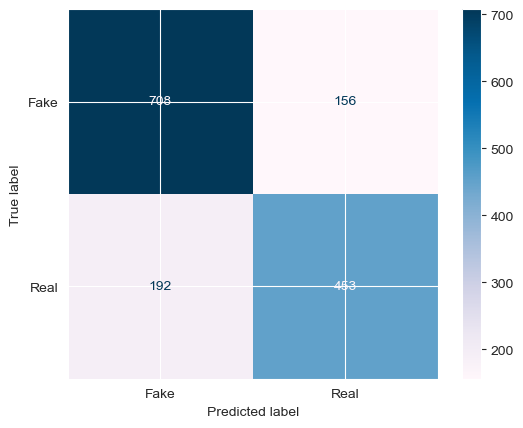

Precision: 0.744
Recall: 0.702
F1: 0.722
Accuracy: 0.769


In [33]:
evaluate(svm_model,x_train_bow,y_train, x_test_bow,y_test,'svm')

Evaluation of the Random Forest model on test set


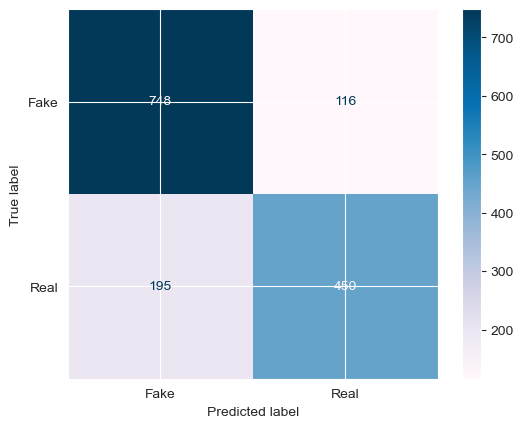

Precision: 0.795
Recall: 0.698
F1: 0.743
Accuracy: 0.794


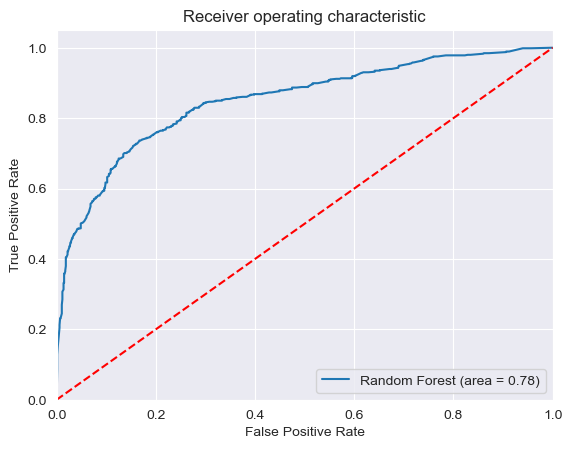

In [34]:
evaluate(rf_model,x_train_bow,y_train, x_test_bow,y_test,'Random Forest')

#### Task2 - TF-IDF feature generation and traditional ML model
For this step I used *TfidfVectorizer* library in sklearn. 
To keep the relevance of the word that happened concurrently I decided to work with unigram and bigram. 
> NotTF-IDF tries to meke the weight on the words that are rare with the idea that these words can discreminates the classes better. While this may affect the performance of the final model, still the number of generated features are high which and like Bag of Word suffers from curse of dimentionality. For this reason we again train the model with models with high bias and low variance.


In [35]:
def tfidf(data):
    
    tf_idf_vectorizer = TfidfVectorizer(ngram_range=(1,2))
    
    tf_idf_train = tf_idf_vectorizer.fit_transform(data)
    
    return tf_idf_train , tf_idf_vectorizer

In [36]:
X_train_tfidf, tfidf_vectorizer = tfidf(x_train)
X_test_tfidf = tfidf_vectorizer.transform(x_test)

In [37]:
X_test_tfidf.shape

(1509, 49048)

In [38]:
x_train_tfidf = X_train_tfidf.toarray()
x_test_tfidf = X_test_tfidf.toarray()

In [39]:
lr_model_tfidf = LogisticRegression()
mnb_model_tfidf = MultinomialNB()



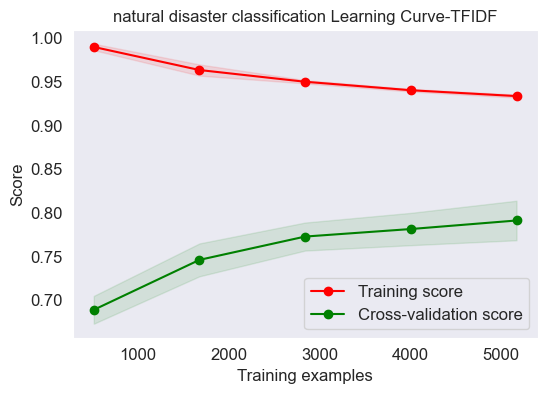

In [40]:
skplt.estimators.plot_learning_curve(mnb_model_tfidf, x_train_tfidf,y_train,
                                     cv=7, shuffle=True, scoring="accuracy",
                                     n_jobs=-1, figsize=(6,4), title_fontsize="large", text_fontsize="large",
                                     title="natural disaster classification Learning Curve-TFIDF");

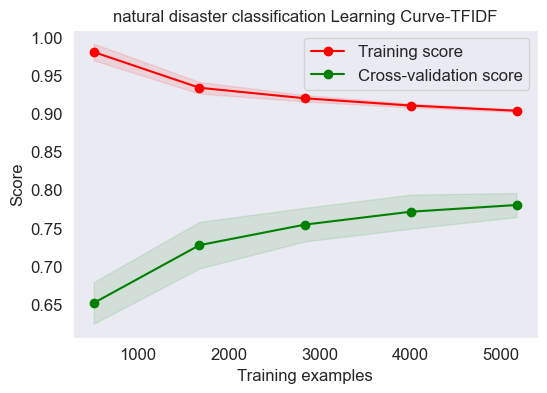

In [41]:
skplt.estimators.plot_learning_curve(lr_model_tfidf, x_train_tfidf,y_train,
                                     cv=7, shuffle=True, scoring="accuracy",
                                     n_jobs=-1, figsize=(6,4), title_fontsize="large", text_fontsize="large",
                                     title="natural disaster classification Learning Curve-TFIDF");

Evaluation of the Naive Bayes model on test set


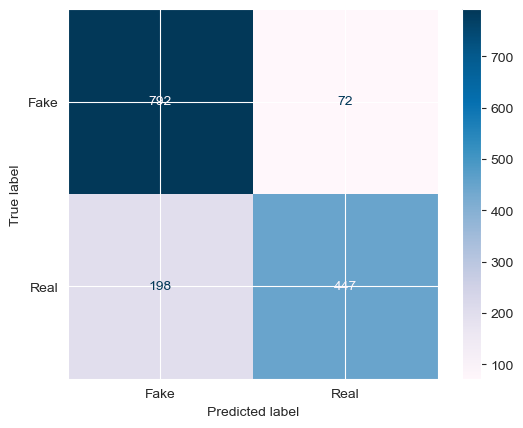

Precision: 0.861
Recall: 0.693
F1: 0.768
Accuracy: 0.821


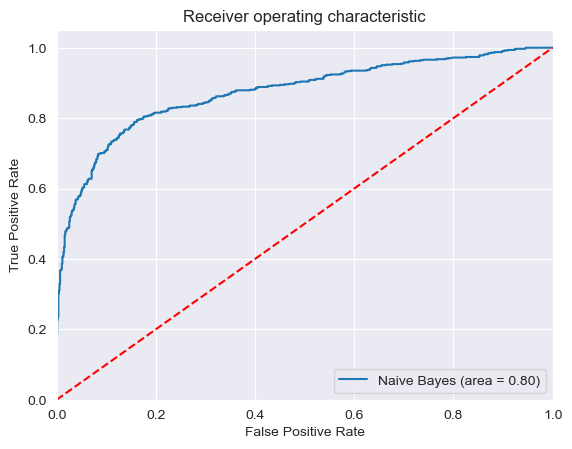

In [42]:
evaluate(mnb_model_tfidf,x_train_tfidf,y_train, x_test_tfidf,y_test,'Naive Bayes')

Evaluation of the Linear Regression model on test set


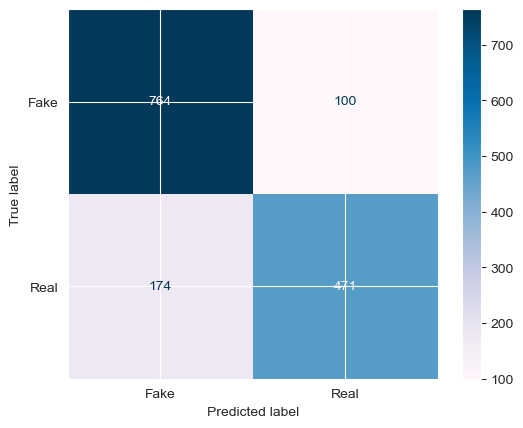

Precision: 0.825
Recall: 0.730
F1: 0.775
Accuracy: 0.818


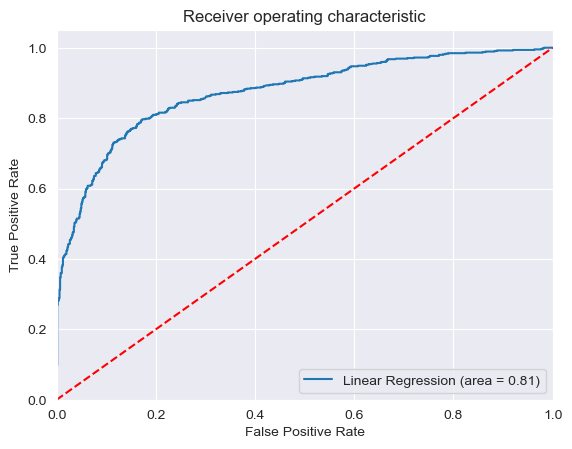

In [43]:
evaluate(lr_model_tfidf,x_train_tfidf,y_train, x_test_tfidf,y_test,'Linear Regression')

### Task3 - Pre-trained word embeddings + linear classifier model

For this task I used GloVe pre-trained word embedding to embed the words in the corpusI used the tweet pre-trained embedding and amongst them I use word embedding size 200 to lose less info as embedding like any other dimention reduction method.


> Note: Another aspect of the text classification which we considered in td-idf method (by ngram) which we didn't use in this part of the project(since we used a simple linear model) is the loosing the order with Word Embedding. One way to keep the word order is to use models like LSTM. 

In order to create sentence embedding using the word embedding, I used AWE(average word embedding). The AWS or avarage pooling is one of the most common methods for making sentence embedding from word embeddings. Minpooling and Maxpooling are other methods for this purpose. Another method of average word embedding is weighted average word embedding with assign a weight to each of the words and use these weights at the time of averaging. 
TF-IDF values can be used for this purpose (due to time limit I have't try the method) and it is expected to result in better performance.
There are pre-trained sentence embedding also available like Doc2Vec but since the purpose of the assignement is to use the word embeddings I haven't try the methods.

In [44]:
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense,SpatialDropout1D,LSTM
from keras.layers import Flatten
from keras.layers import Embedding
from keras.initializers import Constant
from keras.optimizers import Adam

In [45]:
# we will tray Glove pretrained embedding  twitter with 200D 
embedding_dict={}
with open('glove.twitter.27B.200d.txt',encoding ='utf8',mode ='r') as f:
    for line in f:
        values=line.split()
        word=values[0]
        vectors=np.asarray(values[1:],'float32')
        embedding_dict[word]=vectors
f.close()

In [46]:
t = Tokenizer()
t.fit_on_texts(x_train)
vocab_size = len(t.word_index) +1

# integer encoding the messages
encoded_messages_train = t.texts_to_sequences(x_train)
encoded_messages_test = t.texts_to_sequences(x_test)

In [47]:
# maximum length of the tweet in our sample data. 
# I can increase it to maximum size tweet wich is 250 words
w = max(len(em_msg) for em_msg in encoded_messages_train)
print(w)

24


In [48]:
max_length = w
padded_docs_train = pad_sequences(encoded_messages_train,maxlen=max_length,padding = 'post')
padded_docs_test = pad_sequences(encoded_messages_test,maxlen=max_length,padding = 'post')

In [49]:
#creating embedding matrix
embedding_matrix = np.zeros((vocab_size, 200))
for word, i in t.word_index.items():
    embedding_vector = embedding_dict.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [50]:
def embedding_avg(seq):
    total = np.zeros(embedding_matrix.shape[1])
    for w in seq:
        total = np.add(total,embedding_matrix[w])
    avg = total/len(seq)
    
    return total
    

In [51]:
x_train_GloVe = list(map(embedding_avg,encoded_messages_train))
x_test_GloVe = list(map(embedding_avg,encoded_messages_test))

In [52]:
lr_model_GloVe = LogisticRegression(max_iter=200)
# Multinomial Naive Bayes does not accept negative values which using embedding the values are both positive and negative
svm_model_GloVe = LinearSVC()

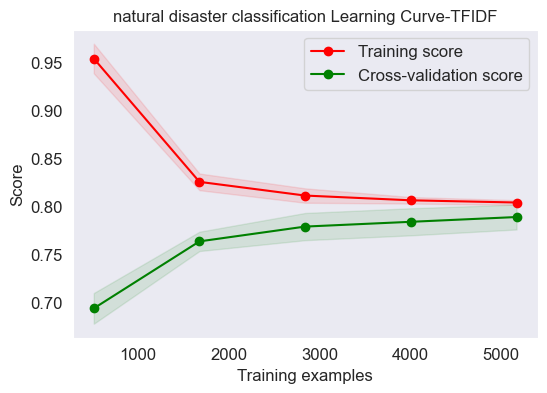

In [53]:
skplt.estimators.plot_learning_curve(lr_model_GloVe, x_train_GloVe,y_train,
                                     cv=7, shuffle=True, scoring="accuracy",
                                     n_jobs=-1, figsize=(6,4), title_fontsize="large", text_fontsize="large",
                                     title="natural disaster classification Learning Curve-GloVe");

Evaluation of the Linear Regression model on test set


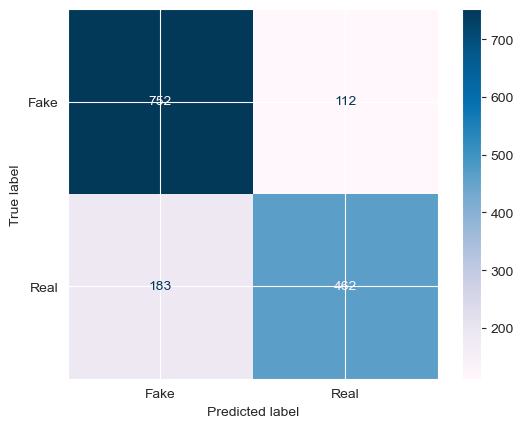

Precision: 0.805
Recall: 0.716
F1: 0.758
Accuracy: 0.805


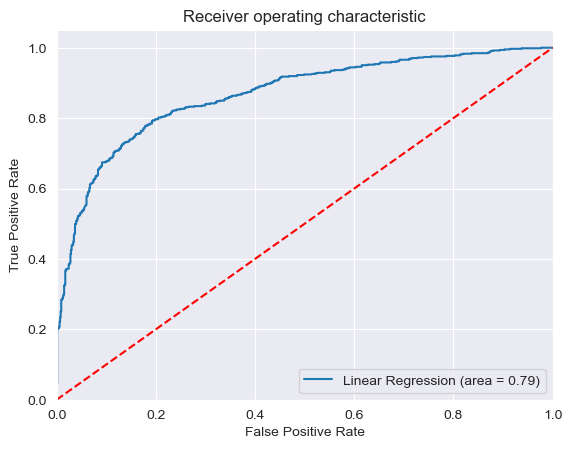

In [54]:
evaluate(lr_model_GloVe,x_train_GloVe,y_train,x_test_GloVe,y_test,'Linear Regression')

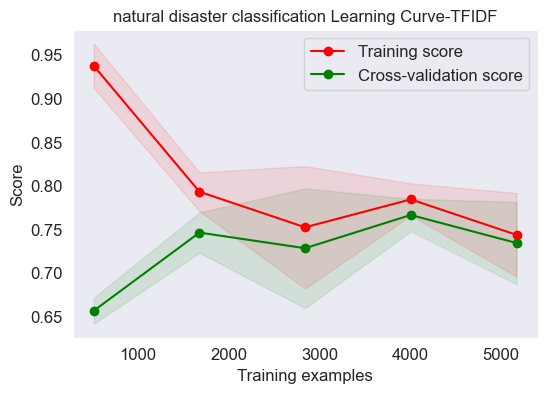

In [55]:
skplt.estimators.plot_learning_curve(svm_model_GloVe, x_train_GloVe,y_train,
                                     cv=7, shuffle=True, scoring="accuracy",
                                     n_jobs=-1, figsize=(6,4), title_fontsize="large", text_fontsize="large",
                                     title="natural disaster classification Learning Curve-GloVe");

Evaluation of the svm model on test set


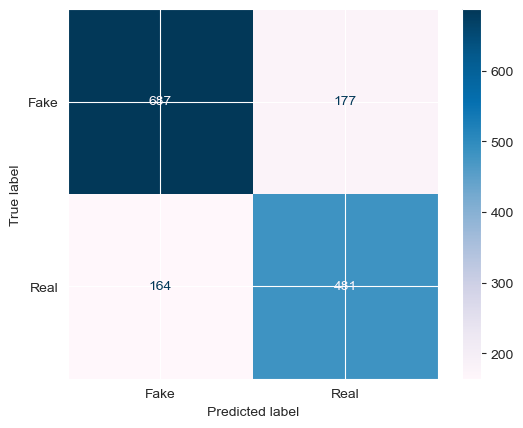

Precision: 0.731
Recall: 0.746
F1: 0.738
Accuracy: 0.774


In [56]:
evaluate(svm_model_GloVe,x_train_GloVe,y_train,x_test_GloVe,y_test,'svm')

In [57]:
from sklearn.linear_model import SGDClassifier

In [58]:
sgd_model_GloVe = SGDClassifier(max_iter=1000000000, loss='log',penalty= 'l2', early_stopping=True)

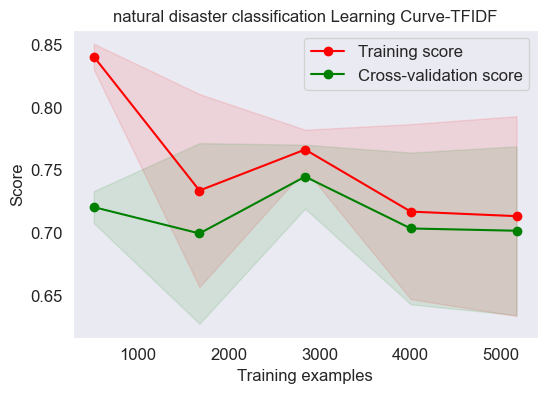

In [59]:
skplt.estimators.plot_learning_curve(sgd_model_GloVe, x_train_GloVe,y_train,
                                     cv=7, shuffle=True, scoring="accuracy",
                                     n_jobs=-1, figsize=(6,4), title_fontsize="large", text_fontsize="large",
                                     title="natural disaster classification Learning Curve-GloVe");

Evaluation of the sgd model on test set


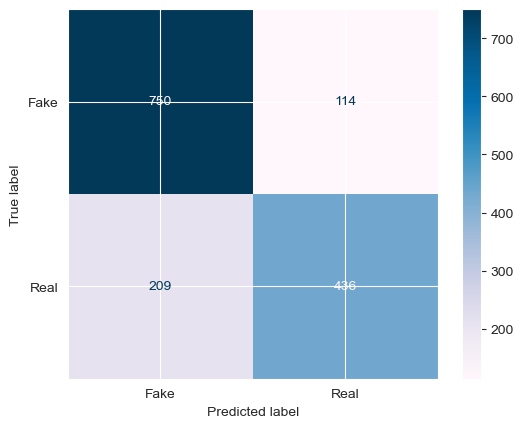

Precision: 0.793
Recall: 0.676
F1: 0.730
Accuracy: 0.786


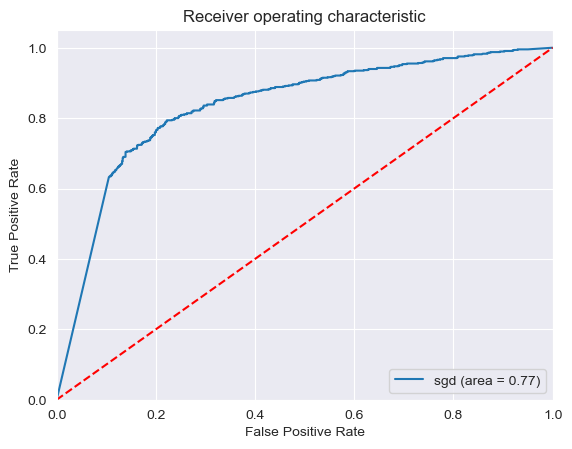

In [60]:
evaluate(sgd_model_GloVe, x_train_GloVe,y_train,x_test_GloVe,y_test,'sgd')

###### Comparing the training models
In this part the result of the different feature engineering alongside with the models that trained using these feature. 
As expected tdidf(bigram) works better than BoW since it includes the coocurrance of words and this keeps some sense of context.
Timewise, as the feature enginerinf method creates less features, as expected, the modles based on the GloVe are faster than the other two. and since the tf-idf creates the most features, for tf_idf the training of the model is slower. 

The plots for each of the models as well as the performance of each method showed above in the process.

**Complexity vs interpretability**

As the model for feature engineering get more complex, as well as the models that we trained on the data, the interpretability of the model would decrese. In term of the ml models here, all of them are linear models wich are interepretable (although the large size of features make explaining of the realtion between the features and the prediction hard) but as the feature engineering gets more complex as in the word embedding, the explainablity get harder as word are embedded and combine and finding the diect relation would be a problem. On top of that, if a deep learning model (e.g. LSTM) is used to model the classification (while it increse the performance of the model), it makes the interpretability more hard.

If the "sufficient accuracy" is not too high, while the interpretability of the model is more important, it is suggested to use tf-idf or BoW for the classsification model. If the accuracy of the model is the most important aspect for the client specially with large volume data, it is suggested to use the word embeddings and more complex ml algorithms. 


In [61]:
performance_df = pd.DataFrame(columns=['model','precision','recall','F1_score','accurace'])
models = [mnb_model,lr_model,svm_model,rf_model,mnb_model_tfidf,lr_model_tfidf,lr_model_GloVe,sgd_model_GloVe]
model_name = ['mnb_model_bow','lr_model_bow','svm_model_bow','rf_model_bow','mnb_model_tfidf','lr_model_tfidf','lr_model_GloVe','sgd_model_GloVe']
test = [x_test_bow, x_test_bow,x_test_bow,x_test_bow, x_test_tfidf, x_test_tfidf, x_test_GloVe,x_test_GloVe]


In [62]:
for i, m in enumerate(models):
    model = model_name[i]
    print(m)
    x_test = test[i]
    y_pred = m.predict(x_test)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    performance_df.loc[len(performance_df.index)] = [model,precision,recall,f1,accuracy]
    

MultinomialNB()
LogisticRegression()
LinearSVC()
RandomForestClassifier()
MultinomialNB()
LogisticRegression()
LogisticRegression(max_iter=200)
SGDClassifier(early_stopping=True, loss='log', max_iter=1000000000)


In [63]:
performance_df

,model,precision,recall,F1_score,accurace
0,mnb_model_bow,0.804636,0.753488,0.778223,0.816435
1,lr_model_bow,0.795181,0.716279,0.753670,0.799867
2,svm_model_bow,0.743842,0.702326,0.722488,0.769384
3,rf_model_bow,0.795053,0.697674,0.743187,0.793903
4,mnb_model_tfidf,0.861272,0.693023,0.768041,0.821074
5,lr_model_tfidf,0.824869,0.730233,0.774671,0.818423
6,lr_model_GloVe,0.804878,0.716279,0.757998,0.804506
7,sgd_model_GloVe,0.792727,0.675969,0.729707,0.785951


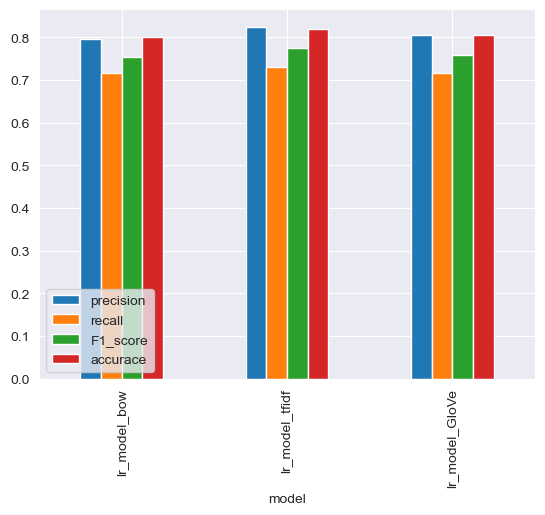

In [64]:
lr_models = ['lr_model_bow','lr_model_tfidf','lr_model_GloVe']
fig, ax = plt.subplots()
performance_df.loc[performance_df['model'].isin(lr_models)].plot.bar(x='model',legend='left',ax=ax)
ax.legend(loc=3)

As expected the precision in TF-IDF higher than the other 2 methods due to adding the co-ocurancy of the words but the rest decreased due to higher dimentionality of feature spece.  